CS4445 Human Centric Computing: Bio-Inspired Computing
Template for Assignment Option 1: DQN CartPole Classic Control

This sample code is based on one of the recommended texts. A small number of errors were deliberately injected into the code.

If using this code as a basis for Option 1:
•	Correct the bugs.
•	Comment the code extensively.
•	Replace CartPole with a different Classic Control problem form gym.
•	Generate more informative plots i.e. plot running average.
•	Consider generating an animation.
•	Play around with hyperparameters and parameters to achieve ‘satisfactory’ performance.

A template will NOT be provided for Option 2. Use this template and modify the following (1) shape of obs and actions (2) network structure, (3) storing and processing of experience, etc.

In [158]:
# Provides access to system-specific parameters and functions
import sys
assert sys.version_info >= (3,10)

In [159]:
# Upgrades the ipykernel package to the latest version. Allows for execution of Python code within Jupyter Notebook
%pip install --upgrade ipykernel

Note: you may need to restart the kernel to use updated packages.


In [160]:
# Installs gym with classic control environments
%pip install -q -U gym[classic_control]==0.25.2

# Installs gym with environments requiring acceptance of ROM license
%pip install -q -U gym[accept-rom-license]==0.25.2

# Installs gym with pendulum environments
%pip install -q -U gym[pendulum]==0.25.2

# Library for game development
%pip install pygame

# Library for numerical computation
%pip install numpy

# Library for data visualization
%pip install matplotlib

# Library for machine learning and neural networks
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [95 lines of output]
      
      
      WARNING, No "Setup" File Exists, Running "buildconfig/config.py"
      Using WINDOWS configuration...
      
      Making dir :prebuilt_downloads:
      Downloading... https://www.libsdl.org/release/SDL2-devel-2.0.16-VC.zip 13d952c333f3c2ebe9b7bc0075b4ad2f784e7584
      
      ---
      For help with compilation see:
          https://www.pygame.org/wiki/CompileWindows
      To contribute to pygame development see:
          https://www.pygame.org/contribute.html
      ---
      
      Traceback (most recent call last):
        File "c:\Users\newsy\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connection.py", line 198, in _new_conn
          sock = connection.create_connection(
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\newsy\AppData\Local\Programs\Python\Python312\Lib\site-packages

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [161]:
# Importing necessary libraries for environment setup, plotting, numerical operations, and deep learning
import os
import gym
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
from collections import deque

In [162]:
# Ensuring compatible TensorFlow version
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.15.0")

In [163]:
# Check if TensorFlow is configured to use a GPU for computation.
if not tf.config.list_physical_devices('GPU'):
    print("Get a GPU ......")

Get a GPU ......


In [164]:
# Lists environments in gym alphabetically
envs = gym.envs.registry
sorted(envs.keys())[:10] + ["..."]
envs['Pendulum-v1']

EnvSpec(id='Pendulum-v1', entry_point='gym.envs.classic_control.pendulum:PendulumEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='Pendulum', version=1)

In [165]:
# Initializing the Pendulum environment with rendering options
env = gym.make('Pendulum-v1', render_mode='rgb_array') # Having it set to 'Human' or 'RGB ARRAY' is not necessary if not being viewed on every step
n_inputs = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]

In [166]:
# Resetting environment to start state
obs = env.reset(seed=42)
obs

# Example of taking a step in the environment with no action to see output format
for e in env.step([0.0]):
    print(e)

[-0.18048953  0.9835769   0.61927676]
-2.9644252412400434
False
{}


In [167]:
# Rendering the environment state as an image
img = env.render()

In [168]:
# Setting random seed for TensorFlow to ensure reproducibility
tf.random.set_seed(42)

# Building a sequential neural network model with specified layers and activation functions
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu", input_shape=(n_inputs,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(n_actions, activation='tanh') # The action space of Pendulum is [-2, 2], tanh activation fits this range.
])


In [169]:
# Getting the maximum action value from the environment for action scaling
action_high = env.action_space.high[0]

In [170]:
# Initializing a replay buffer for storing experiences
replay_buffer = deque(maxlen=400)

In [171]:
# Function to randomly sample a batch of experiences from the replay buffer
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch]) for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [172]:
# Defining a function to perform one step in the environment using the current policy
def play_one_step(env, state, epsilon=0.1):
    if np.random.rand() < epsilon:
        # Exploration: random action
        action = np.random.uniform(-action_high, action_high, n_actions)
    else:
        # Exploitation: action predicted by the model
        action = model.predict(state[np.newaxis])[0]
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [188]:
# Sets random seeds for numpy and TensorFlow for reproducibility, and specifies the number of episodes for training
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
num_episodes = 10 # Change this number as needed
episode_rewards = []

# Training parameters
rewards = []
best_score = 0

In [190]:
# Specifies training parameters like batch size, discount factor for future rewards, and sets up the optimizer and loss function
batch_size = 32
discount_factor = 0.95
action_high = env.action_space.high[0]
model.add(tf.keras.layers.Lambda(lambda x: x * action_high))
optimizer = Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.mean_squared_error

# Function to train the model using experiences sampled from the replay buffer
def train_model(batch_size=32, discount_rate=0.95):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * actions, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [191]:
# Main training loop where the model is trained over a number of episodes, and rewards are plotted
for episode in range(num_episodes):
    obs = env.reset()
    total_reward = 0
    for step in range(200):  # Limit the number of steps per episode if desired
        obs, reward, done, info = play_one_step(env, obs)
        total_reward += reward
        if done:
            break
    episode_rewards.append(total_reward)  # Store the total reward for plotting
    if episode > 50:
        train_model(batch_size=32)
    print("\rEpisode:", episode, "Reward:", total_reward, end="")
    if episode % 10 == 0:
        print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

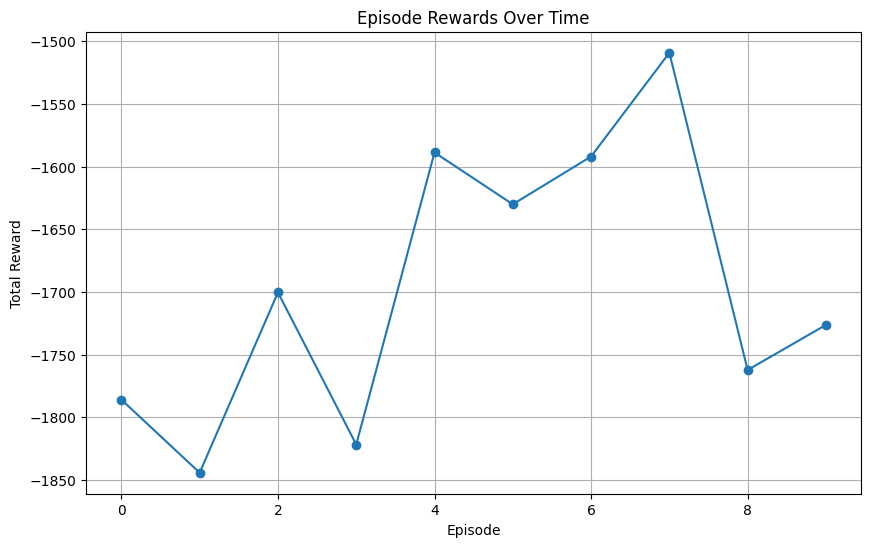

In [192]:
# Plots the total rewards obtained per episode over time
plt.figure(figsize=(10, 6))
plt.plot(range(len(episode_rewards)), episode_rewards, marker='o', linestyle='-')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Episode Rewards Over Time')
plt.grid(True)
plt.show()

In [193]:
def running_average(data, N):
    """Compute the running average of a list with a window size N."""
    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [200]:
# Calculate the running average with a window size of N
N = 9 # You can adjust this window size as needed
rewards_running_avg = running_average(episode_rewards, N)

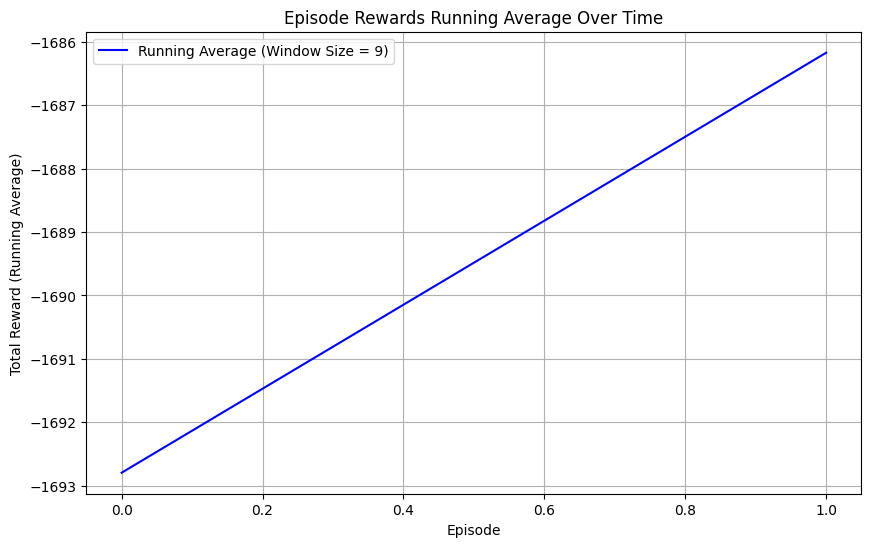

In [201]:
# Plot the Total Reward (Running Average)
plt.figure(figsize=(10, 6))
plt.plot(rewards_running_avg, color='blue', label='Running Average (Window Size = {})'.format(N))
plt.xlabel('Episode')
plt.ylabel('Total Reward (Running Average)')
plt.title('Episode Rewards Running Average Over Time')
plt.legend()
plt.grid(True)
plt.show()